In [485]:
# Dependencies
# !pip install chart-studio plotly plotly-geo
# !pip install plotly
# !pip install shap

In [486]:
import os
import pickle

import pandas as pd
import numpy as np
import itertools

from pathlib import Path

import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
import plotly

from datetime import datetime

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
from IPython.display import display

import shap
from sklearn.model_selection import GridSearchCV

In [487]:
# Display 999 rows of Dataframe
pd.options.display.max_rows = 999

In [488]:
# Defining constants
model_base_path = "/data/models/precipitation/stations"
OK = 1
ERROR = 0
MINUTES = 60
PERC = 40
TEST_INIT_DATE = datetime(2021, 2, 1).date()

In [489]:
# Lists the data csv
!ls /data/stations/2021-03-02

benque_prec.csv			 hawkesworth_bridge_wtlv_min.csv
central_farm_prec.csv		 santa_elena_prec.csv
chaa_creek_prec.csv		 santa_elena_wtlv1.csv
hawkesworth_bridge_prec.csv	 santa_elena_wtlv_max.csv
hawkesworth_bridge_wtlv1.csv	 santa_elena_wtlv_min.csv
hawkesworth_bridge_wtlv_max.csv


## Data Pre-processing Functions

In [490]:
# Combines the csv creating a DataFrame with all data
def read_data(path):
    df_all = None

    # Show all csv ending with _prec in all dirs inside this path
    for f in Path(path).rglob('*_prec*.csv'):
    
        # Ignore spreadsheets of Benque and Santa Elena
        if "benque" in str(f) or "santa" in str(f):
            continue
    
        # Get the filename, without the path
        station = os.path.basename(f).split('_prec')[0]
    
        # datetime and update_at are combined as one date column
        _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
        _df['station'] = station
    
        if df_all is None:
            df_all = _df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)
        
    # Remove updated_at and variable_id columns 
    df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
    
    return(df_all)

In [491]:
# Groups the data by a number of minutes
def group_data_by(df_all_data, minutes):

    # Group by minutes, aggregating with "sum"
    df_aggregated = df_all_data.groupby([pd.Grouper(key="datetime", freq=f"{minutes}min"), "station", "station_id"]).sum()
    df_aggregated.reset_index(inplace=True)
    
    # Transform the "stations" in columns and sets the "datetime" as index
    data = df_aggregated[['station', 'measured', 'datetime']].pivot(index='datetime', columns='station', values='measured')
    data.sort_index(inplace=True)
    
    # Remove rows with NAN values
    data.dropna(inplace=True)
    
    return(data)

In [492]:
# Adds the "label" for all rows or in rows inside the "indexes"
def add_label(data, label, indexes):
    labeled_data = data.copy()

    # All rows
    if(indexes is None):   
         labeled_data.loc[:, 'label'] = label
    
    # Just "indexes" rows
    else:
        labeled_data.loc[indexes, 'label'] = label
                
    return(labeled_data)

In [493]:
# Split the data into train and test set. Train: data before the "day". Test: data after the "day"
def split_df(df, x_columns, y_column, day):
    
    df = df.reset_index()
    
    # Train
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    # Test
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print("\n  Split Result:")
    print("  Train:")
    print("    - X_train: {}".format(X_train.shape))
    print("    - y_train: {}".format(y_train.shape))
    
    print("\n  Test:")
    print("   - X_test: {}".format(X_test.shape))
    print("   - y_test: {}\n".format(y_test.shape))
    
    train = {
        'data': X_train,
        'labels': y_train
    }
    
    test = {
        'data': X_test,
        'labels': y_test
    }
    
    return(train, test)

In [494]:
# Inserts a "perc"% of error in data (hawkesworth receives zero values and "ERROR" label)
def insert_artificial_error(original_data, perc):
    
    # Make a copy of data (don't want a pointer)
    data = original_data.copy()
    
    # Selects the hawkesworth data greater than zero and select the indexes of perc% of them
    indexes = data[data['hawkesworth_bridge']>0].sample(frac=perc/100.0, random_state=0).index
    
    # Sets zero to the values corresponding to the indexes
    data.loc[indexes, 'hawkesworth_bridge'] = 0.0  # no precipitation

    # Sets all labels to "OK" value
    labeled_data = add_label(data, ERROR, indexes)
    
    return(labeled_data)

In [495]:
# Get the rows of y that are artificial errors
def getErrorRows(y):
    rows = np.where(y == ERROR)[0]
    
    return(rows)

## Model Functions

In [496]:
# Alternative version of Confusion Matrix for Unsupervised Classifiers
# Scikit: https://github.com/scikit-learn/scikit-learn/issues/12700
def define_confusion_matrix_(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized Confusion Matrix")
    else:
        print('\nConfusion Matrix, Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Feature Importance Functions

In [497]:
# Gini Importance: The higher, the more important the feature.
## The importance of a feature is computed as the (normalized)
## total reduction of the criterion brought by that feature. 
## https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/ensemble/_forest.py
def feature_importances(model, features_names):
    all_importances = []
    
    # Discover the feature importance of each estimator
    for tree in model.estimators_:
        if tree.tree_.node_count > 1:
            all_importances.append(tree.feature_importances_)

    # Calculates the combined feature importance
    all_importances = np.mean(all_importances, axis=0, dtype=np.float64)
    feature_importances = all_importances / np.sum(all_importances)

    # Shows the importances of each feature
    importances = pd.DataFrame([feature_importances], columns=features_names)
    
    print("Feature Importances:")
    print(importances)
    
    return(feature_importances)

In [498]:
# Plots feature importance values
def plot_feature_importances(model, features_names, X_train):
    
    # Gets the standard deviation of all estimators feature importances
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    # Sort and get the indexes and features names
    indexes = np.argsort(feature_importances_)[::-1]
    features_names_sorted = [features_names[i] for i in indexes]

    # Print the feature ranking
    print("\nFeature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indexes[f], feature_importances_[indexes[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), feature_importances_[indexes],
            color="r", yerr=std[indexes], align="center")

    plt.xticks(range(X_train.shape[1]), features_names_sorted)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

## Permutation Importances Function

In [499]:
# Avaliation of the score of a model, when a feature value is randomly sorted
## The decrease in score informs how much the model dependes on the feature
def permutation_importances(model, data):
    X_val = data[['central_farm', 'chaa_creek', 'hawkesworth_bridge']]
    y_val = data['label']
    r = permutation_importance(model, X_val, y_val, scoring="accuracy", n_repeats=30, random_state=0)

    for i in r.importances_mean.argsort()[::-1]:
        print(f"{X_val.columns[i]:18}: "
              f"{r.importances_mean[i]:6.3f}"
              f" +/- {r.importances_std[i]:.3f}")

## Best Aggregation Interval Function 

In [500]:
# Finds best aggregation interval, used in data to group by minutes
def find_best_aggregation_interval():
    
    # Defines the range of minutes: [10, 20, 30, 40, 50, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200, 1260, 1320, 1380, 1440]
    minutes = list(range(5, 60, 5))
    minutes.extend(list(range(60, 24* 60 + 1, 60)))
    
    # Reads data
    df_all_data = read_data('/data/stations')

    results = []
    for minute in minutes:
        print(f"\n\nMinute: {minute}")
        
        # ----------------------------- Preprocessing Data -------------------------------

        # Groups data by "MINUTES"
        data = group_data_by(df_all_data, minute)

        # Adds "OK" for all examples
        data = add_label(data, OK, None)

        # Inserts "PERC"% of artificial errors
        data = insert_artificial_error(data, PERC)

        # Gets the columns of interest
        columns = ['central_farm', 'chaa_creek', 'hawkesworth_bridge']

        # Divide the data in training and test set
        ## Test set starts in "TEST_INIT_DATE"
        train, test = split_df(data, columns, 'label', TEST_INIT_DATE)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Define the params of the model, create, train and save
        IF = IsolationForestModel()
        IF.init(100, 10, 0.1, True, 42, True)
        IF.build()
        IF.train(train["data"])

        # Makes predictions
        predictions = IF.predict(test["data"])
        labels = test["labels"].to_numpy()

        # Inverts the labels
        m = Metric()
        predicted, expected = m.invertes_result(predictions, labels)
        
        # Model F1-Score
        f1_score = m.f1_score(predicted, expected)
      
        # Adds on the list
        results.append((minute, f1_score))
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by f1-score
    sorted_results = sorted(results, key=lambda tup: tup[1], reverse=True)

    print("\nMinutes:   F1-Score:")
    for minute, f1_score in sorted_results:
        print("{:6}   =>   {:.4}%".format(minute, f1_score*100.0))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------

## Best Sample Size (Artificial Errors) Function

In [501]:
# Finds best sample size to inject artificial errors
def find_best_sample_size(minute):
    
    percs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    
    # Reads data
    df_all_data = read_data('/data/stations')

    results = []

    print("Minute: {}\n".format(minute))

    # Test the interval
    for perc in percs:
        print("\nSample Size: {}%".format(perc))
    
        # ----------------------------- Preprocessing Data -------------------------------

        # Groups data by "MINUTES"
        data = group_data_by(df_all_data, minute)

        # Adds "OK" for all examples
        data = add_label(data, OK, None)

        # Inserts "PERC"% of artificial errors
        data = insert_artificial_error(data, perc)

        # Gets the columns of interest
        columns = ['central_farm', 'chaa_creek', 'hawkesworth_bridge']

        # Divide the data in training and test set
        ## Test set starts in "TEST_INIT_DATE"
        train, test = split_df(data, columns, 'label', TEST_INIT_DATE)
        # --------------------------------------------------------------------------------
        
        # ----------------------------------- Model --------------------------------------
        
        # Define the params of the model, create, train and save
        IF = IsolationForestModel()
        IF.init(100, 10, 0.1, True, 42, True)
        IF.build()
        IF.train(train["data"])

        # Makes predictions
        predictions = IF.predict(test["data"])
        labels = test["labels"].to_numpy()

        # Inverts the labels
        m = Metric()
        predicted, expected = m.invertes_result(predictions, labels)
        
        # Model F1-Score
        print("   - ", end="")
        f1_score = m.f1_score(predicted, expected)
      
        # Adds on the list
        results.append((minute, perc, f1_score))
        # --------------------------------------------------------------------------------
        
    # ------------------------------- Gets best results ----------------------------------
    
    # Sort the results by f1-score
    sorted_results = sorted(results, key=lambda tup: tup[2], reverse=True)

    print("\nBest Params:")
    for m, p, f1_score in sorted_results:
        print("\n  Params:")
        print("   - Aggregation: {}min".format(m))
        print("   - Sample Size: {}%".format(p))
        print("   - F1-Score: {:.4}%\n".format(f1_score*100.0))
        
    return(sorted_results[:5])
    # ------------------------------------------------------------------------------------

## Model Class

In [502]:
# Class that defines the Isolation Forest model
class IsolationForestModel:
    
    # Defines the params
    def init(self, n_estimators, max_samples, contamination, bootstrap, random_state, warm_start):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.contamination = contamination
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.warm_start = warm_start
        self.model = None
        self.modelFit = None
    # ------------------------------------------------------------------------------------
    
    # Creates the model
    def build(self):
        self.model = IsolationForest(n_estimators = self.n_estimators,
                                    max_samples = self.max_samples,
                                    contamination = self.contamination,
                                    bootstrap = self.bootstrap,
                                    random_state = self.random_state,
                                    warm_start = self.warm_start)
    
    # ------------------------------------------------------------------------------------
    # Train the model
    def train(self, X):
        self.modelFit = self.model.fit(X)
 
    # ------------------------------------------------------------------------------------
    # Makes the predictions
    def predict(self, X):
        predictions = self.model.predict(X)
        predictions[predictions == -1] = 0
        
        return(predictions)
        
    # ------------------------------------------------------------------------------------
    # Saves the model (pickle)
    def save(self):
        
        # Defining the filename
        filename_model = f'{model_base_path}/if_no_rain.pickle'
        model_dir = os.path.dirname(filename_model)
        
        # Saving
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(filename_model, "wb") as f:
            pickle.dump(self.model, f)
            
    # ------------------------------------------------------------------------------------
    # Plots one of the estimators (in estimator_index) inside the forest
    def plot_tree_structure(self, data, estimator_index):
        X_val = data[['central_farm', 'chaa_creek', 'hawkesworth_bridge']]
        y_val = data['label']
    
        print("Number of Estimators: {}".format(len(self.model.estimators_)))
        print("{}º Estimator Tree:\n".format(estimator_index+1))
        
        # Export as dot file
        export_graphviz(self.model.estimators_[estimator_index], 
                        out_file='itree-hawkesworth_bridge-no-rain.dot', 
                        feature_names=X_val.columns,
                        class_names=['0', '1'],
                        filled = True)

        # Convert to png using system command (requires Graphviz)
        from subprocess import call
        call(['dot', '-Tpng', 'tree-hawkesworth_bridge-no-rain.dot', '-o', 
              'tree-hawkesworth_bridge-no-rain.png', '-Gdpi=600'])
    # ------------------------------------------------------------------------------------

## Metrics Functions

In [503]:
# Class of all metrics to use in model
class Metric:
    
    # Changes the labels:
    ## Before:
    ### Normal data label: 1
    ### Anomalous data label: 0
    ## After:
    ### Normal data label: 0
    ### Anomalous data label: 1
    def invertes_result(self, original_pred, original_expec):
        
        predicted = original_pred.copy()
        expected = original_expec.copy()
        
        # Predicted:
        ## Change the value of "normal data" to -1
        predicted[predicted == 1] = -1
        
        ## Change the value of "anomalous data" to 1
        predicted[predicted == 0] = 1
        
        ## Change the value of "normal data" to 0
        predicted[predicted == -1] = 0
        
        # --------------------------------------------------------------------------------
        # Expected:
        ## Change the value of "normal data" to -1
        expected[expected == 1] = -1
        
        ## Change the value of "anomalous data" to 1
        expected[expected == 0] = 1
        
        ## Change the value of "normal data" to 0
        expected[expected == -1] = 0
        
        return(predicted, expected)
    # ------------------------------------------------------------------------------------
    
    # Model Accuracy: (TP + TN) / (TP + TN+ FP + FN): how often is the classifier correct
    def accuracy(self, predicted, expected):
        
        accuracy = metrics.accuracy_score(expected, predicted)
        print("Accuracy: {:.4}%".format(accuracy*100.0))
        return(accuracy)
    
    # ------------------------------------------------------------------------------------
    # Model Precision: TP / (TP + FP): how accurate your positive predictions are
    def precision(self, predicted, expected):
            
        precision = metrics.precision_score(expected, predicted)
        print("Precision: {:.4}%".format(precision*100.0))
        return(precision)
    
    # ------------------------------------------------------------------------------------
    # Model Recall: TP / (TP + FN): how good you find all the actual positives
    def recall(self, predicted, expected):
        
        recall = metrics.recall_score(expected, predicted)
        print("Recall: {:.4}%".format(recall*100.0))
        return(recall)
    
    # ------------------------------------------------------------------------------------
    # Model F1-Score: 2 * (Precision * Recall) / (Precision + Recall): combine Precision 
    # and Recall in one value
    def f1_score(self, predicted, expected):
        
        f1_score = metrics.f1_score(expected, predicted)
        print("F1-Score: {:.4}%".format(f1_score*100.0))
        return(f1_score)
    
    # ------------------------------------------------------------------------------------
    # Calcules accuracy, precision, recall and f1_score
    def show_all_metrics(self, predicted, expected):
        
        accuracy = self.accuracy(predicted, expected)
        precision = self.precision(predicted, expected)
        recall = self.recall(predicted, expected)
        f1_score = self.f1_score(predicted, expected)
        
        return([accuracy, precision, recall, f1_score])
    # ------------------------------------------------------------------------------------
    
    # Plot the Confusion Matrix (normal and normalized)
    def plot_confusion_matrix(self, predicted, expected):
        
        class_names = [ERROR, OK]

        cm = confusion_matrix(expected, predicted)

        titles_options = [("Confusion matrix, without normalization", None),
                          ("Normalized confusion matrix", 'true')]

        for title, normalize in titles_options:
            disp = define_confusion_matrix_(cm, classes=class_names, normalize=normalize, title=title)

            plt.show()
    # ------------------------------------------------------------------------------------

## Grid Search Model

In [504]:
# Class of Grid Search
class GridSearch:
    
    # Defines the params
    def init(self, params, estimator, scoring):
        self.params = params
        self.scoring = scoring
        self.estimator = estimator
        self.model = None
        self.modelFit = None
    # ------------------------------------------------------------------------------------
        
    # Creates the model
    def build(self):
        self.model = GridSearchCV(self.estimator, self.params, 
                                  scoring=self.scoring, return_train_score=True, verbose=1)
    # ------------------------------------------------------------------------------------
    
    # Trains
    def fit(self, X_train, y_train):
        print("\nGrid Search:")
        print(" - Estimated Runtime: number of fits * 0.2 secs\n")
        self.modelFit = self.model.fit(X_train, y_train)
    # ------------------------------------------------------------------------------------
    
    # Show all results
    def show_results(self):
        
        # Prints the best params found by Grid Search
        params = self.model.cv_results_["params"]
        scores = self.model.cv_results_["mean_train_score"]
        indexes = np.argsort(scores)[::-1]
        
        print("\nResults:")
        for index in indexes:
            print("\n - ({}): Params:".format(index))
            for param_name in params[index]:
                param_value = params[index][param_name]
                print("     {}: {}".format(param_name, param_value))
            print("\n - ({}): Scores:".format(index))
            print("     F1-Score: {:.4}%".format(scores[index]*100.0))
            print("\n\n")
    # ------------------------------------------------------------------------------------
    
    # Returns the best params
    def get_best_params(self):
        params = self.model.cv_results_["params"]
        scores = self.model.cv_results_["mean_train_score"]
        indexes = np.argsort(scores)[::-1]
        index = indexes[0]
        best_params = params[index]
        print("Best Params:")
        print(best_params)
        
        return(best_params)
    # ------------------------------------------------------------------------------------

## Main

In [505]:
# Reads data
df_all_data = read_data('/data/stations')

# # Groups data by "MINUTES"
data = group_data_by(df_all_data, MINUTES)

# Adds "OK" for all examples
data = add_label(data, OK, None)

# Inserts "PERC"% of artificial errors
data = insert_artificial_error(data, PERC)

# Gets the columns of interest
columns = ['central_farm', 'chaa_creek', 'hawkesworth_bridge']

# Divide the data in training and test set
# Test set starts in "TEST_INIT_DATE"
train, test = split_df(data, columns, 'label', TEST_INIT_DATE)

# Print the number of examples that are an artificial error in train and test set
numTrainError = len(getErrorRows(train["labels"]))
numTestError = len(getErrorRows(test["labels"]))
print("Number of Train Errors: {}".format(numTrainError))
print("Number of Test Errors: {}".format(numTestError))


  Split Result:
  Train:
    - X_train: (5305, 3)
    - y_train: (5305,)

  Test:
   - X_test: (723, 3)
   - y_test: (723,)

Number of Train Errors: 226
Number of Test Errors: 16


## Model: Basic Isolation Forest

Accuracy: 97.51%
Precision: 44.44%
Recall: 50.0%
F1-Score: 47.06%

Confusion Matrix, Without Normalization


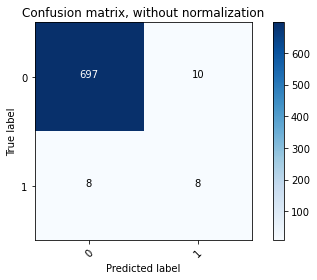


Normalized Confusion Matrix


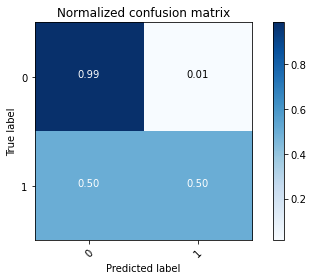

In [506]:
# Model: Basic

# Define the params of the model, create, train and save
IF = IsolationForestModel()
IF.init(100, 10, 0.1, True, 42, True)
IF.build()
IF.train(train["data"])
IF.save()

# Makes predictions
predictions = IF.predict(test["data"])
labels = test["labels"].to_numpy()

# Inverts the labels and print all metrics
m = Metric()
predicted, expected = m.invertes_result(predictions, labels)
all_metrics = m.show_all_metrics(predicted, expected)

# Plots Confusion Matrix
m.plot_confusion_matrix(predicted, expected)

## Feature importance

### Variable Importance Plot — Global Interpretability — SHAP Values

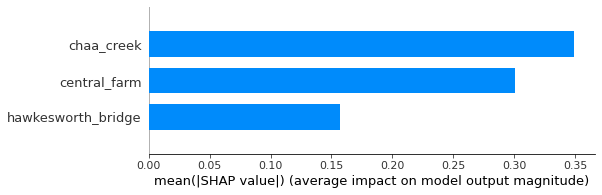

In [507]:
# Variable Importance Plot (Tree Based Models)
## List the most significant variables in descending order
## Top variables contribute more to the model (have high predictive power) than the bottom ones
shap_values = shap.TreeExplainer(IF.model).shap_values(train["data"])
shap.summary_plot(shap_values, train["data"], plot_type="bar")

### Gini Importance

Feature Importances:
   central_farm  chaa_creek  hawkesworth_bridge
0      0.365737     0.44306            0.191203

Feature ranking:
1. feature 1 (0.443060)
2. feature 0 (0.365737)
3. feature 2 (0.191203)


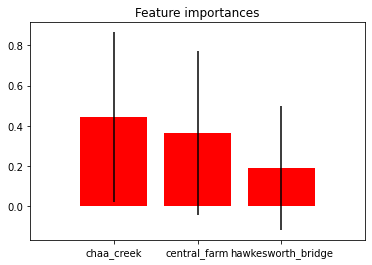

In [508]:
# Gets the features names
features_names = list(train["data"].columns)

# Gets the feature importances
feature_importances_ = feature_importances(IF.model, features_names)

# Plots the feature importances
plot_feature_importances(IF.model, features_names, train["data"])

## Permutation Importance

In [509]:
permutation_importances(IF.model, data)

chaa_creek        :  0.036 +/- 0.001
central_farm      :  0.013 +/- 0.001
hawkesworth_bridge: -0.004 +/- 0.001


## Tree Structure 

In [510]:
# Gets the tree structure of one estimator inside the forest (estimator_index)
estimator_index = 0
IF.plot_tree_structure(data, estimator_index)

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree-hawkesworth_bridge-no-rain.png')

Number of Estimators: 100
1º Estimator Tree:



## Finds Best Aggregation Interval

In [511]:
# Finds the Best Aggregation Interval
best_aggregation_intervals = find_best_aggregation_interval()

print("\nBest Aggregation Interval: {}".format(best_aggregation_intervals[0][0]))



Minute: 5

  Split Result:
  Train:
    - X_train: (63362, 3)
    - y_train: (63362,)

  Test:
   - X_test: (8491, 3)
   - y_test: (8491,)

F1-Score: 12.27%


Minute: 10

  Split Result:
  Train:
    - X_train: (31723, 3)
    - y_train: (31723,)

  Test:
   - X_test: (4275, 3)
   - y_test: (4275,)

F1-Score: 25.9%


Minute: 15

  Split Result:
  Train:
    - X_train: (21169, 3)
    - y_train: (21169,)

  Test:
   - X_test: (2860, 3)
   - y_test: (2860,)

F1-Score: 18.02%


Minute: 20

  Split Result:
  Train:
    - X_train: (15871, 3)
    - y_train: (15871,)

  Test:
   - X_test: (2138, 3)
   - y_test: (2138,)

F1-Score: 32.43%


Minute: 25

  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

F1-Score: 50.79%


Minute: 30

  Split Result:
  Train:
    - X_train: (10605, 3)
    - y_train: (10605,)

  Test:
   - X_test: (1445, 3)
   - y_test: (1445,)

F1-Score: 45.28%


Minute: 35

  Split Result:
  Train:
   

## Model: Best Aggregation Interval


  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

Accuracy: 98.2%
Precision: 39.02%
Recall: 72.73%
F1-Score: 50.79%

Confusion Matrix, Without Normalization


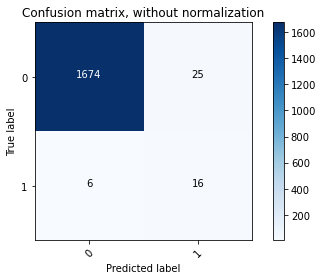


Normalized Confusion Matrix


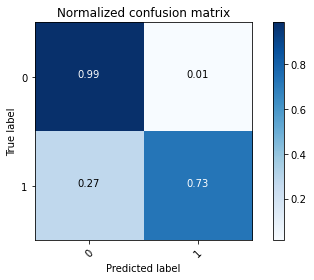

In [512]:
# Model: Best Aggregation Interval

minute = best_aggregation_intervals[0][0]
 
# --------------------------------- Preprocessing Data -----------------------------------
# Reads data
df_all_data = read_data('/data/stations')

# Groups data by "minute"
data = group_data_by(df_all_data, minute)

# Adds "OK" for all examples
data = add_label(data, OK, None)

# Inserts "PERC"% of artificial errors
data = insert_artificial_error(data, PERC)

# Gets the columns of interest
columns = ['central_farm', 'chaa_creek', 'hawkesworth_bridge']

# Divide the data in training and test set
## Test set starts in "TEST_INIT_DATE"
train, test = split_df(data, columns, 'label', TEST_INIT_DATE)
# ----------------------------------------------------------------------------------------

# ---------------------------------------- Model -----------------------------------------

# Define the params of the model, create, train and save
IF = IsolationForestModel()
IF.init(100, 10, 0.1, True, 42, True)
IF.build()
IF.train(train["data"])
IF.save()

# Makes predictions
predictions = IF.predict(test["data"])
labels = test["labels"].to_numpy()

# Inverts the labels and print all metrics
m = Metric()
predicted, expected = m.invertes_result(predictions, labels)
all_metrics = m.show_all_metrics(predicted, expected)

# Plots Confusion Matrix
m.plot_confusion_matrix(predicted, expected)
# ----------------------------------------------------------------------------------------

## Finds the Best Sample Size (Artificial Errors)

In [513]:
# Get the minutes of "Best Aggregation Interval" Optimization
minutes = best_aggregation_intervals[0][0]

# Finds the Best Sample Size
best_sample_size = find_best_sample_size(minutes)

print("Best Sample Size: {}".format(best_sample_size[0][1]))

Minute: 25


Sample Size: 1%

  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

   - F1-Score: 4.545%

Sample Size: 5%

  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

   - F1-Score: 8.889%

Sample Size: 10%

  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

   - F1-Score: 13.04%

Sample Size: 15%

  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

   - F1-Score: 28.0%

Sample Size: 20%

  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

   - F1-Score: 30.77%

Sample Size: 25%

  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1

## Model: Best Sample Size


  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

Accuracy: 98.2%
Precision: 39.02%
Recall: 72.73%
F1-Score: 50.79%

Confusion Matrix, Without Normalization


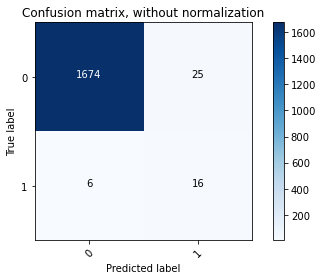


Normalized Confusion Matrix


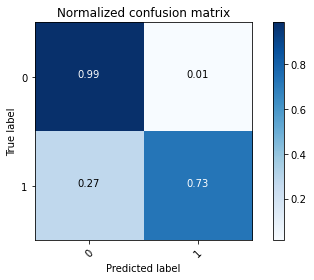

In [520]:
# Model: Best Aggregation Interval

# Get the minutes of "Best Aggregation Interval" Optimization
minutes = best_aggregation_intervals[0][0]

# Get the sample size of "Best Sample Size" Optimization
perc = best_sample_size[0][1]
 
# --------------------------------- Preprocessing Data -----------------------------------
# Reads data
df_all_data = read_data('/data/stations')

# Groups data by "minutes"
data = group_data_by(df_all_data, minutes)

# Adds "OK" for all examples
data = add_label(data, OK, None)

# Inserts "perc"% of artificial errors
data = insert_artificial_error(data, perc)

# Gets the columns of interest
columns = ['central_farm', 'chaa_creek', 'hawkesworth_bridge']

# Divide the data in training and test set
## Test set starts in "TEST_INIT_DATE"
train, test = split_df(data, columns, 'label', TEST_INIT_DATE)
# ----------------------------------------------------------------------------------------

# ---------------------------------------- Model -----------------------------------------

# Define the params of the model, create, train and save
IF = IsolationForestModel()
IF.init(100, 10, 0.1, True, 42, True)
IF.build()
IF.train(train["data"])
IF.save()

# Makes predictions
predictions = IF.predict(test["data"])
labels = test["labels"].to_numpy()

# Inverts the labels and print all metrics
m = Metric()
predicted, expected = m.invertes_result(predictions, labels)
all_metrics = m.show_all_metrics(predicted, expected)

# Plots Confusion Matrix
m.plot_confusion_matrix(predicted, expected)
# ----------------------------------------------------------------------------------------

## Grid Search

In [539]:
# Defines the params of Grid Search
params = [{
    'n_estimators': [50, 100, 150],
    'max_samples': [50, 100, 150],
    'contamination': [0.1, 0.2, 0.3, 0.4, 0.5],
    'max_features': list(range(1, 4, 1)),
    'bootstrap': [ True, False ],
    'random_state': [ 0, 42 ],
    'warm_start': [ True, False ]
}]
params

print("Chosen Params:")
print("  - n_estimators: {}".format(params[0]["n_estimators"]))
print("  - max_samples: {}".format(params[0]["max_samples"]))
print("  - contamination: {}".format(params[0]["contamination"]))
print("  - max_features: {}".format(params[0]["max_features"]))
print("  - bootstrap: {}".format(params[0]["bootstrap"]))
print("  - random_state: {}".format(params[0]["random_state"]))
print("  - warm_start: {}".format(params[0]["warm_start"]))

# ----------- For testing porposes: -----------
# params = [{
#     'n_estimators': list(range(50, 51, 50)),
#     'max_samples': list(range(50, 51, 50)),
#     'contamination': [0.1],
#     'max_features': list(range(1, 2, 1)),
#     'bootstrap': [ True ],
#     'random_state': [ 42 ],
#     'warm_start': [ False ]
# }]
# --------------------------------------------

Chosen Params:
  - n_estimators: [50, 100, 150]
  - max_samples: [50, 100, 150]
  - contamination: [0.1, 0.2, 0.3, 0.4, 0.5]
  - max_features: [1, 2, 3]
  - bootstrap: [True, False]
  - random_state: [0, 42]
  - warm_start: [True, False]


In [540]:
# Runs Grid Search:

# ---------------------------------- Use Best Params -------------------------------------

# Get the minutes of "Best Aggregation Interval" Optimization
minutes = best_aggregation_intervals[0][0]

# Get the sample size of "Best Sample Size" Optimization
perc = best_sample_size[0][1]
# ---------------------------------------------------------------------------------------- 
    
# --------------------------------- Preprocessing Data -----------------------------------
# Reads data
df_all_data = read_data('/data/stations')

# Groups data by "minutes"
data = group_data_by(df_all_data, minutes)

# Adds "OK" for all examples
data = add_label(data, OK, None)

# Inserts "perc"% of artificial errors
data = insert_artificial_error(data, perc)

# Gets the columns of interest
columns = ['central_farm', 'chaa_creek', 'hawkesworth_bridge']

# Divide the data in training and test set
## Test set starts in "TEST_INIT_DATE"
train, test = split_df(data, columns, 'label', TEST_INIT_DATE)
# ----------------------------------------------------------------------------------------

# ---------------------------------- Grid Search Fit -------------------------------------

# Defines the params, creates the model, fits and show results of a Grid Search
GS = GridSearch()
GS.init(params, IsolationForest(), 'f1_micro')
GS.build()
GS.fit(train["data"], train["labels"])
GS.show_results()
best_params = GS.get_best_params()
# ----------------------------------------------------------------------------------------


  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)


Grid Search:
 - Estimated Runtime: number of fits * 0.2 secs

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

Results:

 - (74): Params:
     bootstrap: True
     contamination: 0.1
     max_features: 3
     max_samples: 50
     n_estimators: 50
     random_state: 42
     warm_start: True

 - (74): Scores:
     F1-Score: 90.05%




 - (75): Params:
     bootstrap: True
     contamination: 0.1
     max_features: 3
     max_samples: 50
     n_estimators: 50
     random_state: 42
     warm_start: False

 - (75): Scores:
     F1-Score: 90.05%




 - (615): Params:
     bootstrap: False
     contamination: 0.1
     max_features: 3
     max_samples: 50
     n_estimators: 50
     random_state: 42
     warm_start: False

 - (615): Scores:
     F1-Score: 90.02%




 - (614): Params:
     bootstrap: False
     contamination: 0.1
     max_features: 3

 - (591): Scores:
     F1-Score: 89.53%




 - (55): Params:
     bootstrap: True
     contamination: 0.1
     max_features: 2
     max_samples: 100
     n_estimators: 100
     random_state: 42
     warm_start: False

 - (55): Scores:
     F1-Score: 89.53%




 - (54): Params:
     bootstrap: True
     contamination: 0.1
     max_features: 2
     max_samples: 100
     n_estimators: 100
     random_state: 42
     warm_start: True

 - (54): Scores:
     F1-Score: 89.53%




 - (85): Params:
     bootstrap: True
     contamination: 0.1
     max_features: 3
     max_samples: 100
     n_estimators: 50
     random_state: 0
     warm_start: False

 - (85): Scores:
     F1-Score: 89.53%




 - (84): Params:
     bootstrap: True
     contamination: 0.1
     max_features: 3
     max_samples: 100
     n_estimators: 50
     random_state: 0
     warm_start: True

 - (84): Scores:
     F1-Score: 89.53%




 - (547): Params:
     bootstrap: False
     contamination: 0.1
     max_features: 1
     max_

     warm_start: False

 - (479): Scores:
     F1-Score: 87.93%




 - (480): Params:
     bootstrap: True
     contamination: 0.5
     max_features: 2
     max_samples: 100
     n_estimators: 50
     random_state: 0
     warm_start: True

 - (480): Scores:
     F1-Score: 87.93%




 - (481): Params:
     bootstrap: True
     contamination: 0.5
     max_features: 2
     max_samples: 100
     n_estimators: 50
     random_state: 0
     warm_start: False

 - (481): Scores:
     F1-Score: 87.93%




 - (482): Params:
     bootstrap: True
     contamination: 0.5
     max_features: 2
     max_samples: 100
     n_estimators: 50
     random_state: 42
     warm_start: True

 - (482): Scores:
     F1-Score: 87.93%




 - (483): Params:
     bootstrap: True
     contamination: 0.5
     max_features: 2
     max_samples: 100
     n_estimators: 50
     random_state: 42
     warm_start: False

 - (483): Scores:
     F1-Score: 87.93%




 - (484): Params:
     bootstrap: True
     contamination: 0.5
 

     contamination: 0.4
     max_features: 1
     max_samples: 100
     n_estimators: 100
     random_state: 0
     warm_start: True

 - (340): Scores:
     F1-Score: 87.93%




 - (339): Params:
     bootstrap: True
     contamination: 0.4
     max_features: 1
     max_samples: 100
     n_estimators: 50
     random_state: 42
     warm_start: False

 - (339): Scores:
     F1-Score: 87.93%




 - (366): Params:
     bootstrap: True
     contamination: 0.4
     max_features: 2
     max_samples: 50
     n_estimators: 100
     random_state: 42
     warm_start: True

 - (366): Scores:
     F1-Score: 87.93%




 - (367): Params:
     bootstrap: True
     contamination: 0.4
     max_features: 2
     max_samples: 50
     n_estimators: 100
     random_state: 42
     warm_start: False

 - (367): Scores:
     F1-Score: 87.93%




 - (368): Params:
     bootstrap: True
     contamination: 0.4
     max_features: 2
     max_samples: 50
     n_estimators: 150
     random_state: 0
     warm_start: Tru

     bootstrap: False
     contamination: 0.4
     max_features: 1
     max_samples: 50
     n_estimators: 50
     random_state: 0
     warm_start: False

 - (865): Scores:
     F1-Score: 87.93%




 - (864): Params:
     bootstrap: False
     contamination: 0.4
     max_features: 1
     max_samples: 50
     n_estimators: 50
     random_state: 0
     warm_start: True

 - (864): Scores:
     F1-Score: 87.93%




 - (863): Params:
     bootstrap: False
     contamination: 0.3
     max_features: 3
     max_samples: 150
     n_estimators: 150
     random_state: 42
     warm_start: False

 - (863): Scores:
     F1-Score: 87.93%




 - (862): Params:
     bootstrap: False
     contamination: 0.3
     max_features: 3
     max_samples: 150
     n_estimators: 150
     random_state: 42
     warm_start: True

 - (862): Scores:
     F1-Score: 87.93%




 - (861): Params:
     bootstrap: False
     contamination: 0.3
     max_features: 3
     max_samples: 150
     n_estimators: 150
     random_stat

     warm_start: False

 - (1019): Scores:
     F1-Score: 87.93%




 - (1018): Params:
     bootstrap: False
     contamination: 0.5
     max_features: 2
     max_samples: 50
     n_estimators: 150
     random_state: 42
     warm_start: True

 - (1018): Scores:
     F1-Score: 87.93%




 - (1017): Params:
     bootstrap: False
     contamination: 0.5
     max_features: 2
     max_samples: 50
     n_estimators: 150
     random_state: 0
     warm_start: False

 - (1017): Scores:
     F1-Score: 87.93%




 - (1016): Params:
     bootstrap: False
     contamination: 0.5
     max_features: 2
     max_samples: 50
     n_estimators: 150
     random_state: 0
     warm_start: True

 - (1016): Scores:
     F1-Score: 87.93%




 - (1015): Params:
     bootstrap: False
     contamination: 0.5
     max_features: 2
     max_samples: 50
     n_estimators: 100
     random_state: 42
     warm_start: False

 - (1015): Scores:
     F1-Score: 87.93%




 - (1014): Params:
     bootstrap: False
     conta

     contamination: 0.3
     max_features: 3
     max_samples: 50
     n_estimators: 50
     random_state: 0
     warm_start: False

 - (829): Scores:
     F1-Score: 87.93%




 - (666): Params:
     bootstrap: False
     contamination: 0.2
     max_features: 1
     max_samples: 100
     n_estimators: 100
     random_state: 42
     warm_start: True

 - (666): Scores:
     F1-Score: 87.93%




 - (679): Params:
     bootstrap: False
     contamination: 0.2
     max_features: 1
     max_samples: 150
     n_estimators: 100
     random_state: 42
     warm_start: False

 - (679): Scores:
     F1-Score: 87.93%




 - (678): Params:
     bootstrap: False
     contamination: 0.2
     max_features: 1
     max_samples: 150
     n_estimators: 100
     random_state: 42
     warm_start: True

 - (678): Scores:
     F1-Score: 87.93%




 - (697): Params:
     bootstrap: False
     contamination: 0.2
     max_features: 2
     max_samples: 100
     n_estimators: 50
     random_state: 0
     warm_start

Best Params:
{'bootstrap': True, 'contamination': 0.1, 'max_features': 3, 'max_samples': 50, 'n_estimators': 50, 'random_state': 42, 'warm_start': True}


## Model: Best Grid Search Params, Best Aggregation Interval and Best Sample Size

Best Model:
  - Grid Search: {'bootstrap': True, 'contamination': 0.1, 'max_features': 3, 'max_samples': 50, 'n_estimators': 50, 'random_state': 42, 'warm_start': True}

  - Aggregation Interval: 25

  - Sample Size: 40


  Split Result:
  Train:
    - X_train: (12709, 3)
    - y_train: (12709,)

  Test:
   - X_test: (1721, 3)
   - y_test: (1721,)

Accuracy: 98.2%
Precision: 39.02%
Recall: 72.73%
F1-Score: 50.79%

Confusion Matrix, Without Normalization


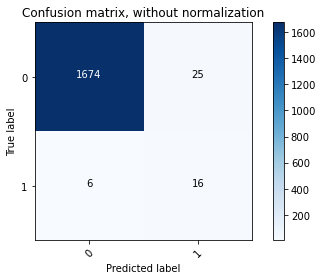


Normalized Confusion Matrix


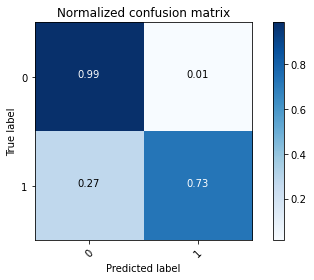

In [547]:
# Best Model:

print("Best Model:")

# Grid Search Best Params
params = best_params
print("  - Grid Search: {}\n".format(params))

# Best Aggregation Intervals
minute = best_aggregation_intervals[0][0]
print("  - Aggregation Interval: {}\n".format(minute))

# Best Sample Size
perc = best_sample_size[0][1]
print("  - Sample Size: {}\n".format(perc))

 
# --------------------------------- Preprocessing Data -----------------------------------
# Reads data
df_all_data = read_data('/data/stations')

# Groups data by "MINUTES"
data = group_data_by(df_all_data, minute)

# Adds "OK" for all examples
data = add_label(data, OK, None)

# Inserts "PERC"% of artificial errors
data = insert_artificial_error(data, perc)

# Gets the columns of interest
columns = ['central_farm', 'chaa_creek', 'hawkesworth_bridge']

# Divide the data in training and test set
## Test set starts in "TEST_INIT_DATE"
train, test = split_df(data, columns, 'label', TEST_INIT_DATE)
# ----------------------------------------------------------------------------------------

# ---------------------------------------- Model -----------------------------------------

# Define the params of the model, create, train and save
IF = IsolationForestModel()
IF.init(params["n_estimators"], 
        params["max_samples"],
        params["contamination"],
        params["bootstrap"],
        params["random_state"],
        params["warm_start"])
IF.build()
IF.train(train["data"])
IF.save()

# Makes predictions
predictions = IF.predict(test["data"])
labels = test["labels"].to_numpy()

# Inverts the labels and print all metrics
m = Metric()
predicted, expected = m.invertes_result(predictions, labels)
all_metrics = m.show_all_metrics(predicted, expected)

# Plots Confusion Matrix
m.plot_confusion_matrix(predicted, expected)
# ----------------------------------------------------------------------------------------

## ROC Curve

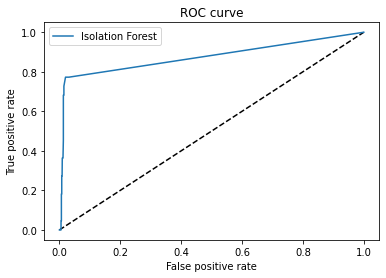

In [542]:
# https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
from sklearn.metrics import roc_curve, auc

# Defines the probabilities to calculate the ROC curve
prob_scores = abs(IF.model.score_samples(test["data"]))
y_true = np.array(test["labels"])
y_probas = prob_scores

# Calculates the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probas, pos_label=0)

# Plot it
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Isolation Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Area Under the Curve (AUC)

In [544]:
AUC = metrics.auc(fpr, tpr)
print("AUC: {:.4}".format(AUC))

AUC: 0.8746
